In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../science.mplstyle")

from sklearn.utils import shuffle


import os


import pickle

from helpers.data_transforms import inverse_transform, clean_data
from helpers.BDT import *
from helpers.physics_functions import *
from helpers.plotting import hist_all_features_array

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
# selecting appropriate device
CUDA = torch.cuda.is_available()
print("cuda available:", CUDA)
device = torch.device("cuda" if CUDA else "cpu")


cuda available: True


In [3]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)
    
    
config_id = "CATHODE_8"

configs_path = f"configs/{config_id}.yml"
with open(configs_path, "r") as file:
    flow_configs = yaml.safe_load(file)
    


Train classifier to discriminate train samples from train data in the SR ONLY
By default, the test set data type is the same as `train_data_id`. There are 2 alternative test sets:
- If the train data is opp sign, one alt test set will be same sign (and vice versa)
- The test set used to construct the ROC curve, which is evaluated on a high-stats dataset

In [4]:
# load in the data

bands = ["SBL", "SR", "SBH"]
data_dict = {}

working_dir = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/logit_08_22/"
#working_dir = "/global/u1/r/rmastand/dimuonAD/projects/powerscaler_0813/"


flow_id = "single_1"
particle_type = "upsilon_shifted"
project_id = "lowmass"


train_samples_id = ""
train_data_id = train_samples_id
if train_data_id == "": 
    alt_test_data_id = "_samesign"
    train_data_id_title = "_oppsign"
elif train_data_id == "_samesign": 
    alt_test_data_id = ""
    train_data_id_title = "_samesign"

ROC_test_data_id = ""

with open(f"{working_dir}/models/{project_id}_{particle_type}{train_samples_id}_nojet/{flow_id}/{config_id}/flow_samples", "rb") as infile: 
    train_samples_dict = pickle.load(infile)

# we actually want the "test band" here -- train is just for flow
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_nojet_test_band_data", "rb") as infile: 
    test_data_dict = pickle.load(infile)

with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{alt_test_data_id}_nojet_test_band_data", "rb") as infile: 
    alt_test_data_dict = pickle.load(infile)

    
# ROC set is evaluated on the FULL high stats dataset
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{ROC_test_data_id}_nojet_train_band_data", "rb") as infile: 
    ROC_test_data_dict = pickle.load(infile)

print(f"Loading classifier train samples from {project_id}_{particle_type}{train_samples_id}")
print(f"Loading classifier train data from {project_id}_{particle_type}{train_data_id}")
print(f"Loading alternative test data from {project_id}_{particle_type}{alt_test_data_id}")
print(f"Loading ROC test data from {project_id}_{particle_type}{ROC_test_data_id}")
print()

with open(f"{working_dir}/models/{project_id}_{particle_type}{train_samples_id}_nojet/{flow_id}/{config_id}/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    print(configs)



Loading classifier train samples from lowmass_upsilon_shifted
Loading classifier train data from lowmass_upsilon_shifted
Loading alternative test data from lowmass_upsilon_shifted_samesign
Loading ROC test data from lowmass_upsilon_shifted

feature_set = ['mu0_iso04', 'mu1_iso04', 'dimu_mass']



In [5]:
# Assemble the test sets -- consists of both SB and SR

feature_set = ['mu0_iso04', 'mu1_iso04', 'dimu_mass']

def assemble_banded_datasets(data_dict, feature_set, bands):
    
    banded_data = {}
    
    for b in bands:
        num_events_band = data_dict[b]["s_inj_data"]["dimu_mass"].shape[0]
        events_band = np.empty((num_events_band, len(feature_set)))
        for i, feat in enumerate(feature_set):
            # default test set
            events_band[:,i] = data_dict[b]["s_inj_data"][feat].reshape(-1,)
        banded_data[b] = events_band
        
    return banded_data
        
 # test set events: not used during flow training
banded_test_data = assemble_banded_datasets(test_data_dict, feature_set, bands)

# alt test set events
banded_alt_test_data = assemble_banded_datasets(alt_test_data_dict, feature_set, bands)

# ROC test set events
banded_ROC_test_data = assemble_banded_datasets(ROC_test_data_dict, feature_set, bands)

num_test_events = banded_test_data["SR"].shape[0]+banded_test_data["SBL"].shape[0]+banded_test_data["SBH"].shape[0]
print(f"Total number of default test events: {num_test_events}.")
num_test_events = banded_alt_test_data["SR"].shape[0]+banded_alt_test_data["SBL"].shape[0]+banded_alt_test_data["SBH"].shape[0]
print(f"Total number of alt test events: {num_test_events}.")
num_test_events = banded_ROC_test_data["SR"].shape[0]+banded_ROC_test_data["SBL"].shape[0]+banded_ROC_test_data["SBH"].shape[0]
print(f"Total number of ROC test events: {num_test_events}.")


SR_min_rescaled = np.min(banded_test_data["SR"][:,-1])
SR_max_rescaled = np.max(banded_test_data["SR"][:,-1])


Total number of default test events: 34998.
Total number of alt test events: 34999.
Total number of ROC test events: 347635.


Training in SR with id: .


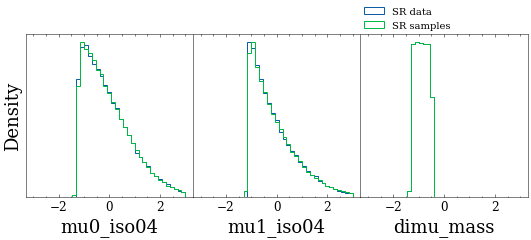

In [6]:
# plot things in the SR

print(f"Training in SR with id: {train_samples_id}.")
hist_all_features_array([train_samples_dict["SR"], train_samples_dict["SR_samples"]], ["SR data", "SR samples"], 
                        feature_set, plot_bound = 3, yscale_log = False)



## Train the BDTs

Train to discriminate (flow samples in SR) from (test data in SR)

In [7]:
import xgboost as xgb

# BDT HYPERPARAMETERS 

n_estimators = 300 # number of boosting stages
max_depth = 5 # max depth of individual regression estimators; related to complexity
learning_rate = 0.1
subsample = 0.7 # fraction of samples to be used for fitting the individual base learners
early_stopping_rounds = 10 # stop training BDT is validation loss doesn't improve after this many rounds



In [8]:
def run_BDT_bump_hunt(flow_samples_SR, data_samples_SR, data_samples_SB, num_folds, num_to_ensemble, 
                      alt_test_sets_data={}, visualize=True):
    
    """
    Classifier is trained only on SR data, to distinguish flow SR samples from SR data
    
    Classifier is evaluated on test data from SR AND SB
    
    Note that alt test sets are NOT split into folds, since we aren't training on them. We do get diff scores for each fold
    """
    
    test_data_splits  = {i:0 for i in range(num_folds)}
    scores_splits = {i:0 for i in range(num_folds)}
    
    # split the alternative test sets
    alt_scores_splits = {}
    alt_data_splits = {}
    for alt_id in alt_test_sets_data.keys():
        alt_scores_splits[alt_id] = {i:0 for i in range(num_folds)}
        # generate a nfold split for the alt test data
        loc_alt_data_split = np.array_split(shuffle(alt_test_sets_data[alt_id]), num_folds) 
        alt_data_splits[alt_id] = {i:loc_alt_data_split[i] for i in range(num_folds)}
        
    # shuffle anything with SB data to mix the low and high masses before splitting 
    flow_samples_SR = shuffle(flow_samples_SR)
    data_samples_SR = shuffle(data_samples_SR)
    data_samples_SB = shuffle(data_samples_SB)
    
    flow_SR_splits = np.array_split(flow_samples_SR, num_folds)
    data_SR_splits = np.array_split(data_samples_SR, num_folds)
    data_SB_splits = np.array_split(data_samples_SB, num_folds) 
    
    for i_fold in range(num_folds):
            
        print(f"Fold {i_fold}:")
        
        """
        ASSEMBLE THE TRAIN / VAL / TEST DATA
        """
        
        # Assemble the train / test data
        training_data, training_labels = [], []
        validation_data, validation_labels = [], []
        testing_data = []

        for ii in range(num_folds):
            
            # test set comprised of SR and SB data
            if ii == i_fold:
                testing_data.append(data_SR_splits[ii])
                testing_data.append(data_SB_splits[ii])
                
            # validation set: flow SR samples, data SR sampkes
            elif ((ii+1)%num_folds) == i_fold:
                validation_data.append(flow_SR_splits[ii])
                validation_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                validation_data.append(data_SR_splits[ii])
                validation_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                
            else:
                training_data.append(flow_SR_splits[ii])
                training_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                training_data.append(data_SR_splits[ii])
                training_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                
        X_train_fold = np.concatenate(training_data)
        Y_train_fold = np.concatenate(training_labels)
        X_val_fold = np.concatenate(validation_data)
        Y_val_fold = np.concatenate(validation_labels)
        
        X_test_fold = np.concatenate(testing_data)
        
        # record the local fold data
        test_data_splits[i_fold] = X_test_fold
     
        """
        SORT THE WEIGHTS OUT
        """
        
        # First do the weights for the regular BC (non-decorr)
        class_weight = {0: 1, 1: sum(Y_train_fold==0)[0]/sum(Y_train_fold==1)[0]}
        class_weights_train = class_weight[0]*(1.0-Y_train_fold)+class_weight[1]*Y_train_fold
        class_weights_val = class_weight[0]*(1.0-Y_val_fold)+class_weight[1]*Y_val_fold
        
        """
        COMBINE W/ DECORRELATED TRAINING
        """
        # we only want to train on the non-mass features

        X_train_fold = X_train_fold[:,:-1]
        X_val_fold = X_val_fold[:,:-1]

        w_train_fold = class_weights_train
        w_val_fold = class_weights_val

        # shuffle for good measure
        X_train_fold, Y_train_fold, w_train_fold = shuffle(X_train_fold, Y_train_fold, w_train_fold)
        X_val_fold, Y_val_fold, w_val_fold = shuffle(X_val_fold, Y_val_fold, w_val_fold)
        
        X_test_fold = X_test_fold[:,:-1]
        
        
        print(f"X train shape: {X_train_fold.shape}, Y train shape: {Y_train_fold.shape}, w train shape: {w_train_fold.shape}.")
        print(f"X val shape: {X_val_fold.shape}, Y val shape: {Y_val_fold.shape}, w val shape: {w_val_fold.shape}.")
        print(f"X test shape: {X_test_fold.shape}." )
        
        """
        INITIALIZE SCORE OBJECTS
        """
        
        scores_fold = np.empty((X_test_fold.shape[0], num_to_ensemble))
        alt_scores_fold = {}
        for alt_id in alt_test_sets_data.keys():
            alt_scores_fold[alt_id] = np.empty((alt_data_splits[alt_id][i_fold].shape[0], num_to_ensemble))
            
   
        """
        TRAIN ENSEMBLE OF TREES
        """
    
        if visualize:
            plt.figure()
        
        for i_tree in range(num_to_ensemble):
            
            #print("   Network number:", i_tree)
            random_seed = i_fold*num_to_ensemble + i_tree + 1
                
                
            eval_set = [(X_train_fold, Y_train_fold), (X_val_fold, Y_val_fold)]
            

            bst_i = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                              subsample=subsample,  early_stopping_rounds=early_stopping_rounds,
                              objective='binary:logistic', 
                                      random_state = random_seed, eval_metric="logloss")

            bst_i.fit(X_train_fold, Y_train_fold, sample_weight=w_train_fold, 
                      eval_set=eval_set, sample_weight_eval_set = [w_train_fold, w_val_fold],
                      verbose=False)
            results_f = bst_i.evals_result()
            losses = results_f["validation_0"]["logloss"]
            losses_val = results_f["validation_1"]["logloss"]
            best_epoch = bst_i.best_iteration


            # get scores
            scores_fold[:,i_tree] = bst_i.predict_proba(X_test_fold, iteration_range=(0,bst_i.best_iteration))[:,1]
            for alt_id in alt_test_sets_data.keys():
                alt_scores_fold[alt_id][:,i_tree] = bst_i.predict_proba(alt_data_splits[alt_id][i_fold][:,:-1], iteration_range=(0,bst_i.best_iteration))[:,1]


            
            if visualize:
                
                plt.plot(losses, label = f"{i_tree}", color = f"C{i_tree}")
                plt.plot(losses_val, color = f"C{i_tree}", linestyle = "dashed")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.axvline(best_epoch, color = f"C{i_tree}")
                plt.title(f"Fold {i_fold}")
        
        if visualize:
            plt.legend()
            plt.show()
        
            
            
        """
        AVERAGE OVER ENSEMBLE
        """
        
        
            
        scores_splits[i_fold] = np.mean(scores_fold, axis = 1)
        for alt_id in alt_test_sets_data.keys():
            alt_scores_splits[alt_id][i_fold] = np.mean(alt_scores_fold[alt_id], axis = 1)

        """
        plt.figure()
        plt.hist2d(test_data_splits[i_fold][:,-1], scores_splits[i_fold], bins = 40, cmap = "hot", density = True)
        plt.xlabel("M (rescaled)")
        plt.ylabel("score")
        #plt.axvline(SR_min_rescaled, color = "red")
        #plt.axvline(SR_max_rescaled, color = "red")
        plt.colorbar()
        plt.colorbar()
        plt.show()
        
        
        
        plt.figure()
        plt.hist2d(alt_data_splits["FPR_validation"][i_fold][:,-1], alt_scores_splits["FPR_validation"][i_fold], bins = 40, cmap = "hot", density = True)
        plt.xlabel("M (rescaled)")
        plt.ylabel("score")
        plt.axvline(SR_min_rescaled, color = "red")
        plt.axvline(SR_max_rescaled, color = "red")
        plt.title("FPR_validation")
        plt.colorbar()
        plt.show()
        """
 
        
    return test_data_splits, scores_splits, alt_data_splits, alt_scores_splits




On pseudoexperiment 0 of 10...
Fold 0:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


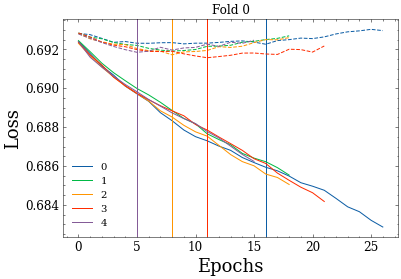

Fold 1:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20916, 2), Y val shape: (20916, 1), w val shape: (20916, 1).
X test shape: (7000, 2).


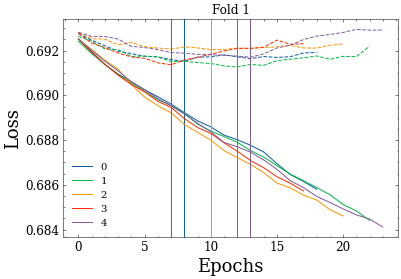

Fold 2:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


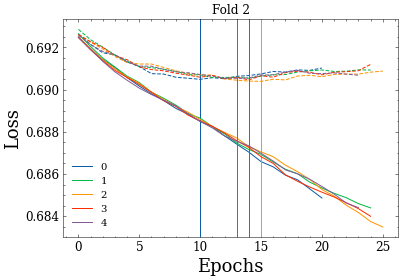

Fold 3:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


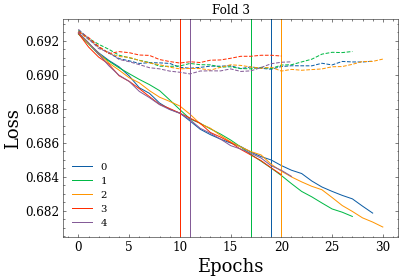

Fold 4:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


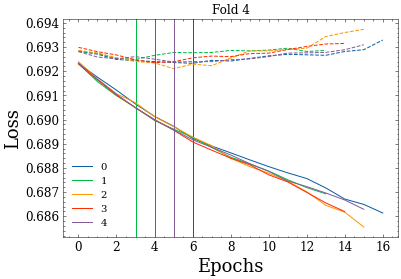

On pseudoexperiment 1 of 10...
Fold 0:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


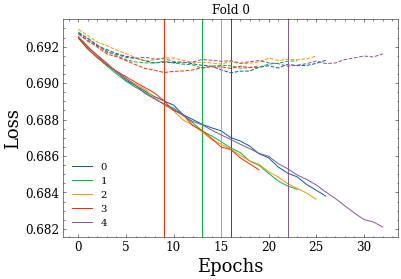

Fold 1:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20916, 2), Y val shape: (20916, 1), w val shape: (20916, 1).
X test shape: (7000, 2).


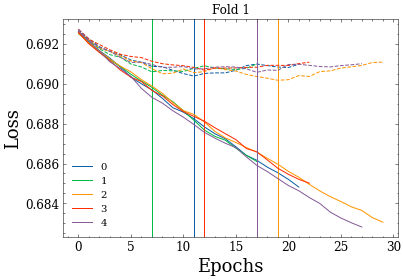

Fold 2:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


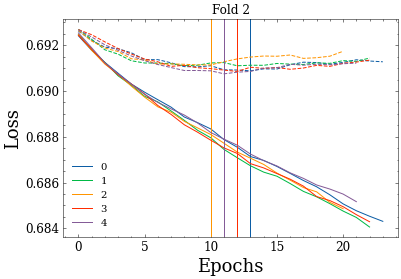

Fold 3:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


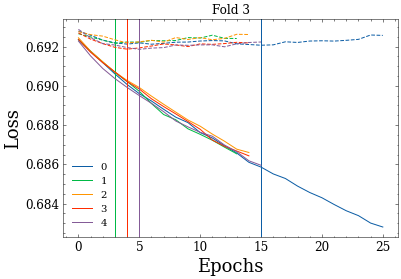

Fold 4:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


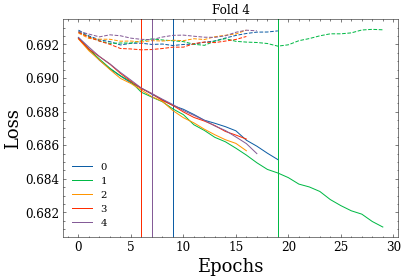

On pseudoexperiment 2 of 10...
Fold 0:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


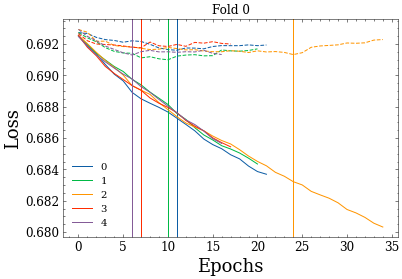

Fold 1:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20916, 2), Y val shape: (20916, 1), w val shape: (20916, 1).
X test shape: (7000, 2).


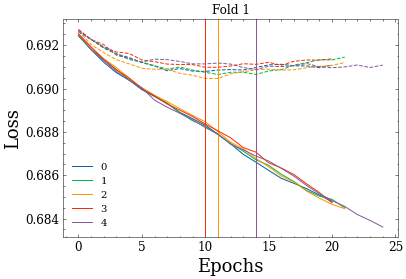

Fold 2:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


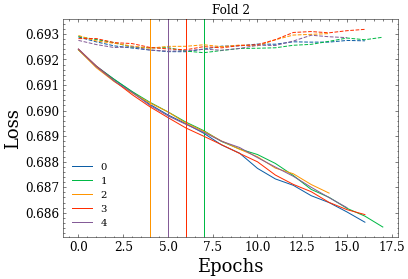

Fold 3:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


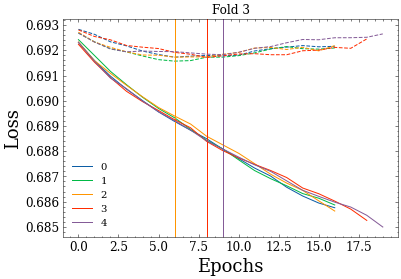

Fold 4:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


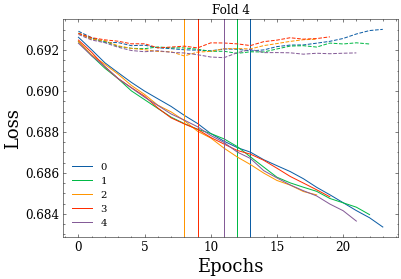

On pseudoexperiment 3 of 10...
Fold 0:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


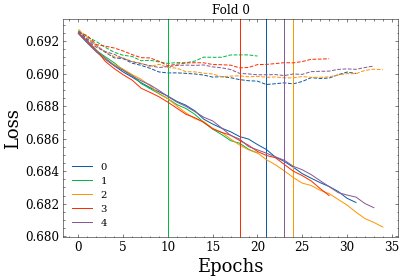

Fold 1:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20916, 2), Y val shape: (20916, 1), w val shape: (20916, 1).
X test shape: (7000, 2).


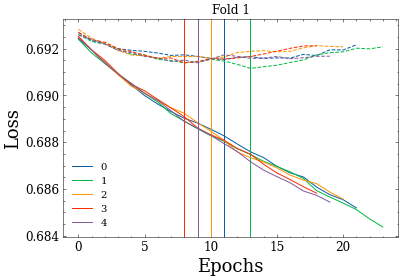

Fold 2:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


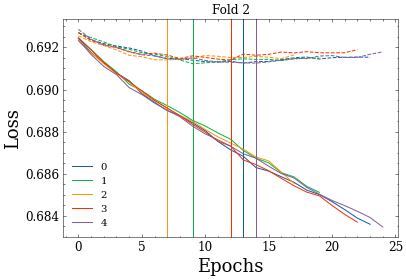

Fold 3:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


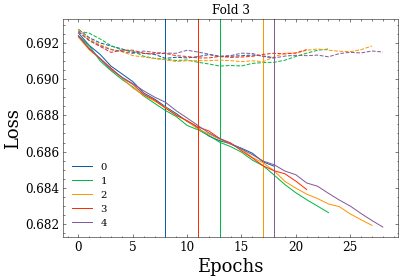

Fold 4:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


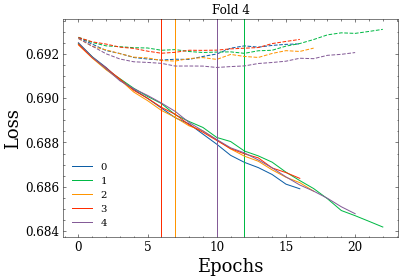

On pseudoexperiment 4 of 10...
Fold 0:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


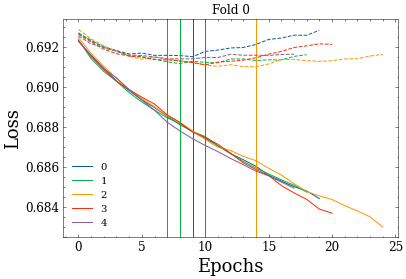

Fold 1:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20916, 2), Y val shape: (20916, 1), w val shape: (20916, 1).
X test shape: (7000, 2).


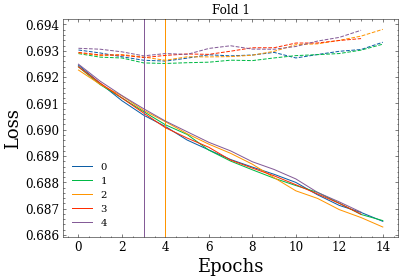

Fold 2:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


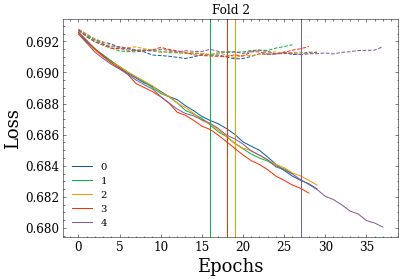

Fold 3:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


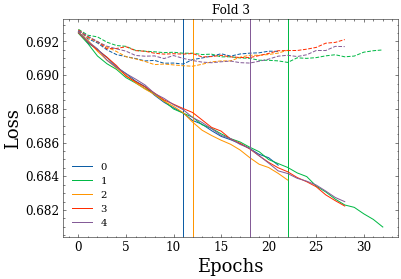

Fold 4:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


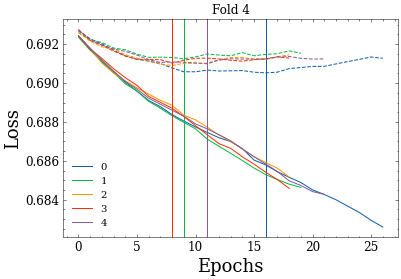

On pseudoexperiment 5 of 10...
Fold 0:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


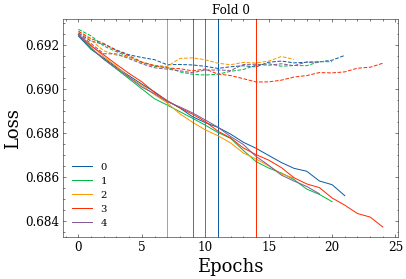

Fold 1:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20916, 2), Y val shape: (20916, 1), w val shape: (20916, 1).
X test shape: (7000, 2).


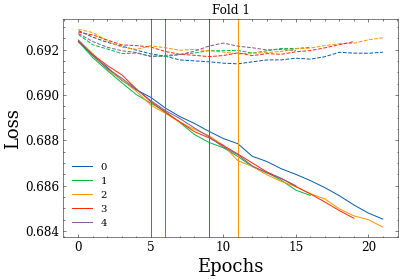

Fold 2:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


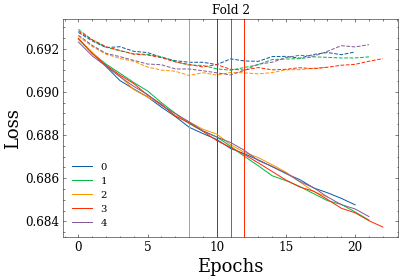

Fold 3:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


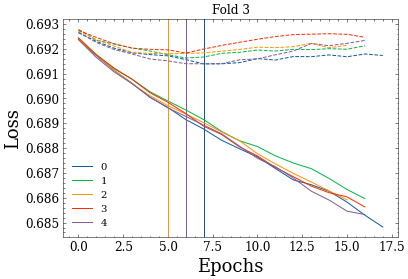

Fold 4:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


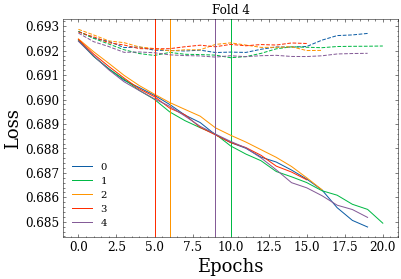

On pseudoexperiment 6 of 10...
Fold 0:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


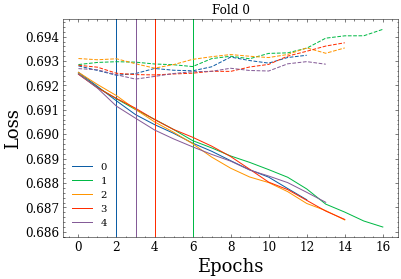

Fold 1:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20916, 2), Y val shape: (20916, 1), w val shape: (20916, 1).
X test shape: (7000, 2).


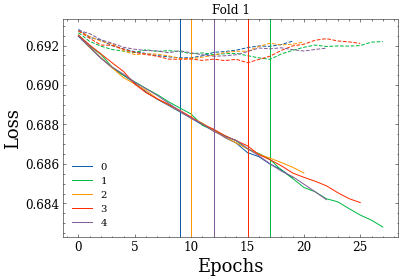

Fold 2:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


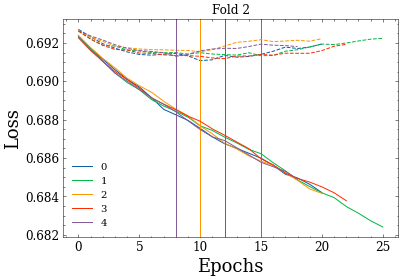

Fold 3:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


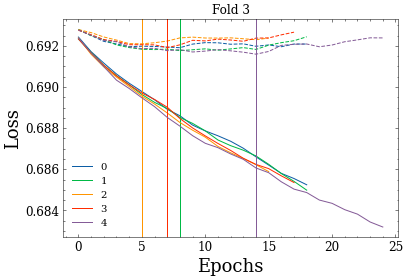

Fold 4:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


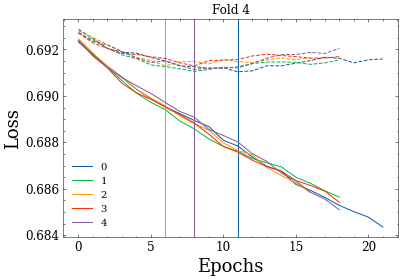

On pseudoexperiment 7 of 10...
Fold 0:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


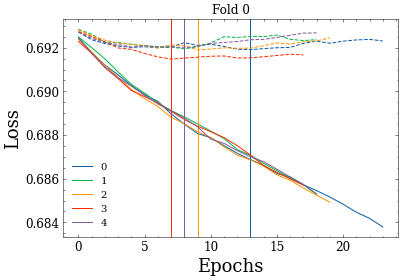

Fold 1:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20916, 2), Y val shape: (20916, 1), w val shape: (20916, 1).
X test shape: (7000, 2).


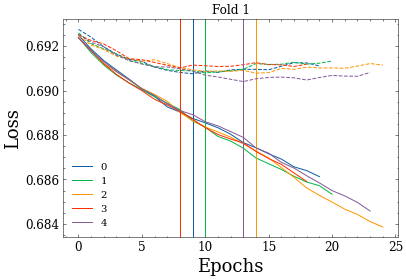

Fold 2:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


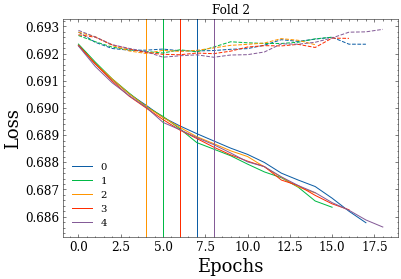

Fold 3:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


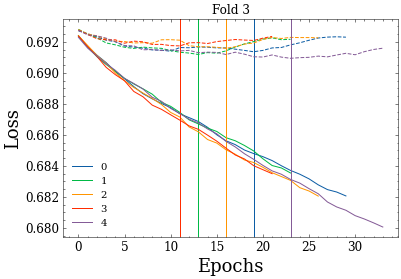

Fold 4:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


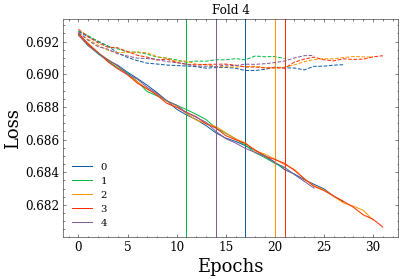

On pseudoexperiment 8 of 10...
Fold 0:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


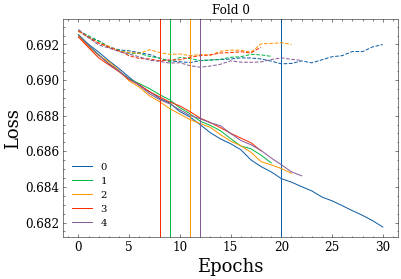

Fold 1:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20916, 2), Y val shape: (20916, 1), w val shape: (20916, 1).
X test shape: (7000, 2).


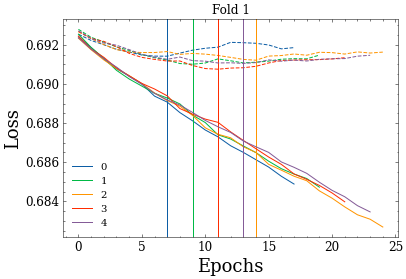

Fold 2:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


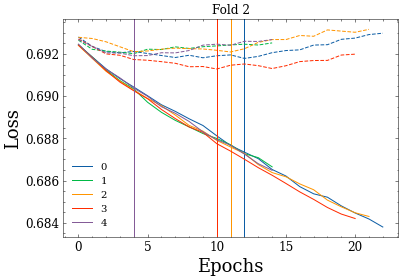

Fold 3:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


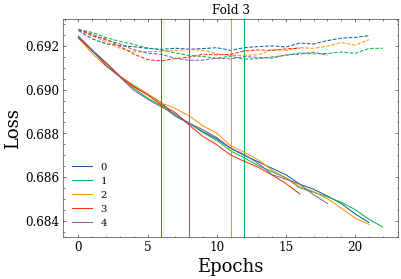

Fold 4:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


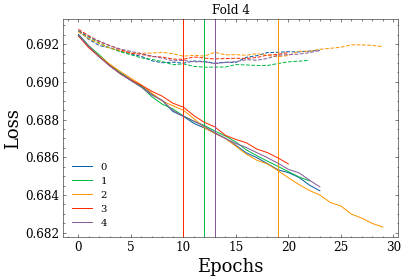

On pseudoexperiment 9 of 10...
Fold 0:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


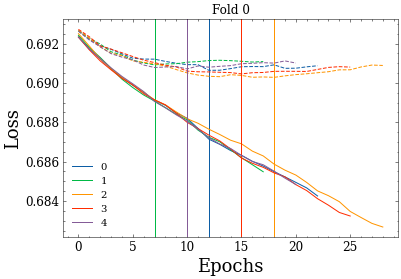

Fold 1:
X train shape: (62745, 2), Y train shape: (62745, 1), w train shape: (62745, 1).
X val shape: (20916, 2), Y val shape: (20916, 1), w val shape: (20916, 1).
X test shape: (7000, 2).


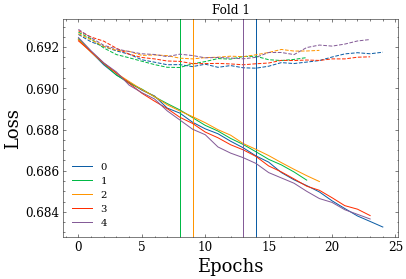

Fold 2:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (7000, 2).


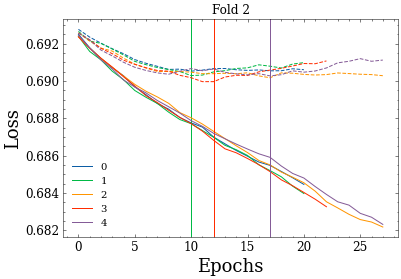

Fold 3:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


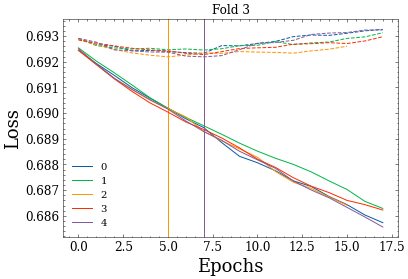

Fold 4:
X train shape: (62746, 2), Y train shape: (62746, 1), w train shape: (62746, 1).
X val shape: (20915, 2), Y val shape: (20915, 1), w val shape: (20915, 1).
X test shape: (6999, 2).


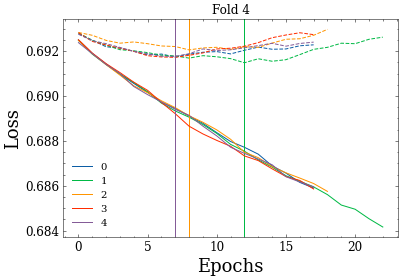

All done!


In [9]:
# Train a classifier to discriminate SR samples from SR data

n_folds = 5 # k-fold for the classifier 
n_to_ensemble = 5 # how many BDTs to train for a single pseudoexperiment

num_bootstraps = 10 # how many pseudoexperiments to run

all_test_data_splits = {pseudo_e:{} for pseudo_e in range(num_bootstraps)}
all_scores_splits = {pseudo_e:{} for pseudo_e in range(num_bootstraps)}
all_alt_data_splits = {pseudo_e:{} for pseudo_e in range(num_bootstraps)}
all_alt_scores_splits = {pseudo_e:{} for pseudo_e in range(num_bootstraps)}

def bootstrap_array(data_array):
    indices_to_take = np.random.choice(range(data_array.shape[0]), size = data_array.shape[0], replace = True) 
    #return data_array[indices_to_take]
    return data_array

for pseudo_e in range(num_bootstraps):
    
    print(f"On pseudoexperiment {pseudo_e} of {num_bootstraps}...")
    
    # assemble the bootstrapped datasets
    # I think the validation set and the flow samples should NOT be bootstrapped
    
    # boostrapped alt set:
    loc_alt_test_set = np.vstack([bootstrap_array(banded_alt_test_data["SR"]),bootstrap_array(banded_alt_test_data["SBL"]),bootstrap_array(banded_alt_test_data["SBH"])])
    loc_ROC_test_set = np.vstack([bootstrap_array(banded_ROC_test_data["SR"]),bootstrap_array(banded_ROC_test_data["SBL"]),bootstrap_array(banded_ROC_test_data["SBH"])])
    loc_SB_test_set = np.vstack([bootstrap_array(clean_data(banded_test_data["SBL"])),bootstrap_array(clean_data(banded_test_data["SBH"]))])

        
    loc_alt_test_sets_data = {"FPR_validation":train_samples_dict["SR_samples_validation"],
                          "alt":loc_alt_test_set,
                          "ROC":loc_ROC_test_set}
    
    # make sure the input data is also bootstrapped
    loc_test_data_splits, loc_scores_splits, loc_alt_data_splits, loc_alt_scores_splits = run_BDT_bump_hunt(clean_data(train_samples_dict["SR_samples"]), 
                                            bootstrap_array(clean_data(banded_test_data["SR"])), loc_SB_test_set, n_folds, n_to_ensemble, 
                                                alt_test_sets_data=loc_alt_test_sets_data,
                                                                         visualize=True
                                                                                                           )
    
    all_test_data_splits[pseudo_e] = loc_test_data_splits
    all_scores_splits[pseudo_e] = loc_scores_splits
    all_alt_data_splits[pseudo_e] = loc_alt_data_splits
    all_alt_scores_splits[pseudo_e] = loc_alt_scores_splits

print("All done!")

## Analysis


### True bump hunt

- Define a polynomial form for the background fit
- For each cut on the classifier score:
  - Fit the background on the cut SB data
  - Estimate N_bkg
  - Calculate S/B, S/sqrt(B)



In [10]:
with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01]

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_bootstraps)}

for pseudo_e in range(num_bootstraps):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff


To plot, it really only makes sense to try 1 pseudoexperiment.

Probably we don't want to use this plot anyways. We should use actual data.

Text(0.5, 1.0, 'upsilon_shifted_oppsign (trained on _oppsign)\nmu0_iso04  mu1_iso04\n')

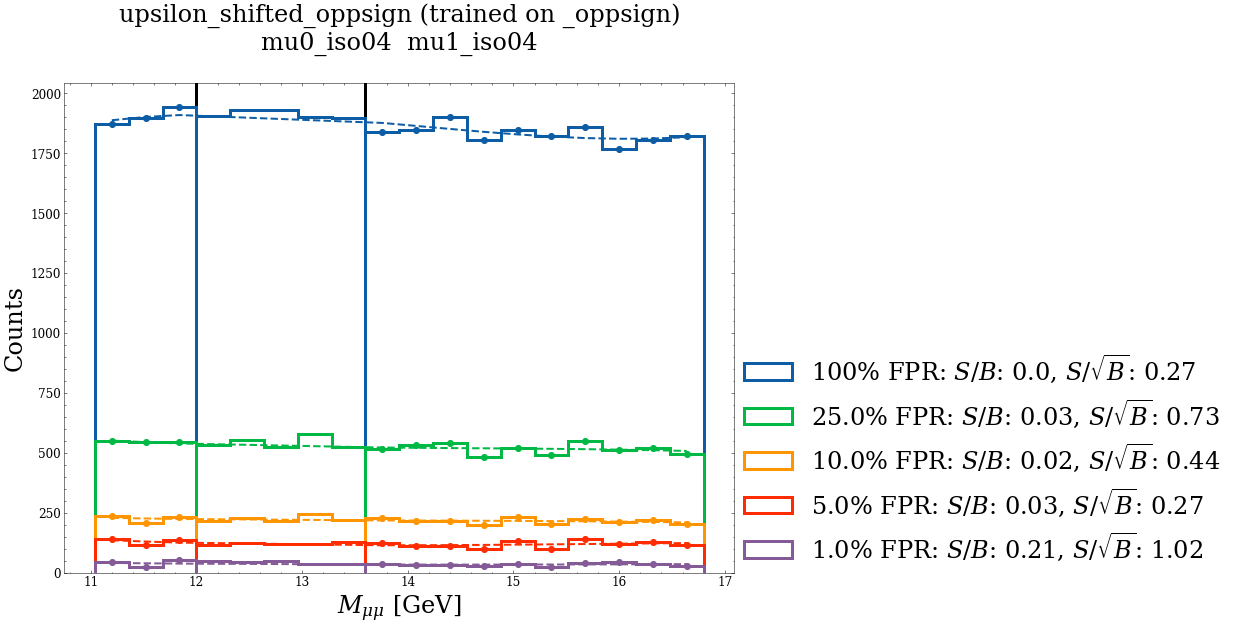

In [11]:
SB_left = float(workflow[particle_type]["SB_left"])
SR_left = float(workflow[particle_type]["SR_left"])
SR_right = float(workflow[particle_type]["SR_right"])
SB_right = float(workflow[particle_type]["SB_right"])
    
remove_edge = True
pseudo_e_to_plot= 0



x = np.linspace(SB_left, SB_right, 100)

# get bins, bin centers
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, remove_edge)


fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio

plt.figure(figsize = (12, 9))
for t, threshold in enumerate(fpr_thresholds):
    
    # corrections to SR / SB efficiencies
    filtered_masses = []
    
    for i_fold in range(n_folds):
        
        
        loc_true_masses = scaler.inverse_transform(np.array(all_test_data_splits[pseudo_e_to_plot][i_fold][:,-1]).reshape(-1,1))
        loc_scores = all_scores_splits[pseudo_e_to_plot][i_fold]
        
        loc_filtered_masses, _, _, _ = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs[pseudo_e_to_plot][i_fold][threshold],
                                                                                           plot_bins_left, plot_bins_right, plot_bins_SR)
        

        filtered_masses.append(loc_filtered_masses)

        

    filtered_masses = np.concatenate(filtered_masses)

    
    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all,)
    #print("chi2/dof:", chi2/n_dof)
    # plot the fit function
    plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
    
    # calculate significance of bump
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, SR_left, SR_right, popt)
    
    if threshold == 1:
        S_total, B_total = num_S_expected_in_SR, num_B_expected_in_SR
   
        

    y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
    plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")
    
    

print() 
plt.legend(loc = (1, 0), fontsize = 24)


plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)


plt.title(f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", fontsize = 24)







Repeat for alternative test set

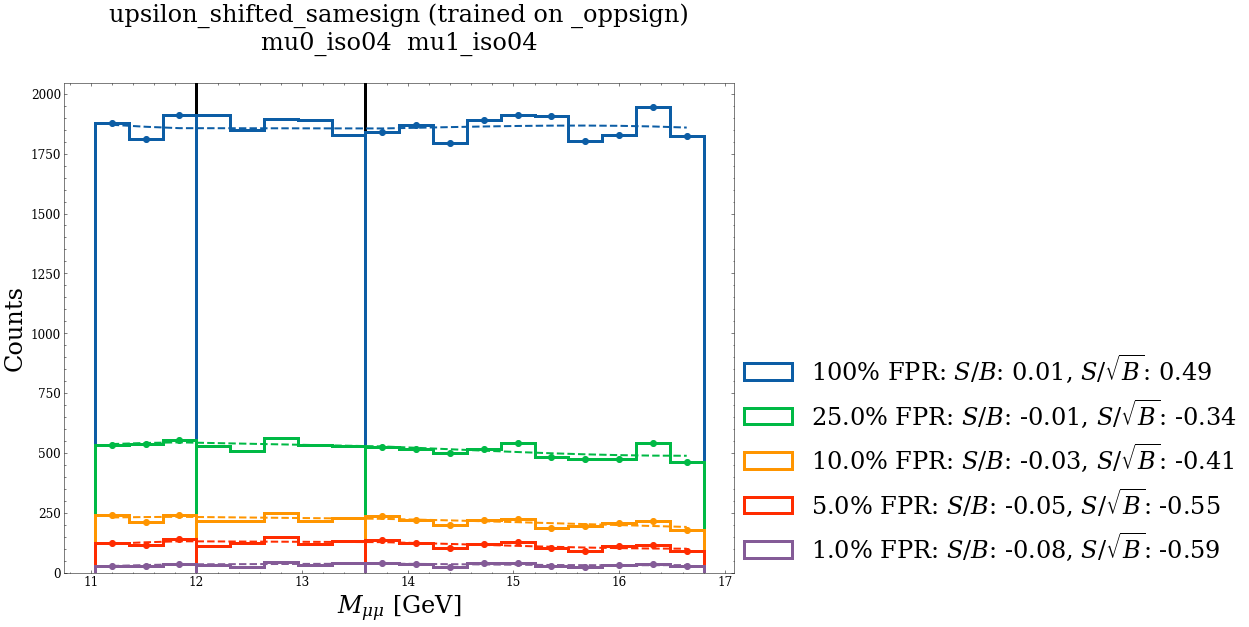

In [12]:
fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio



plt.figure(figsize = (12, 9))
for t, threshold in enumerate(fpr_thresholds):
    
    # corrections to SR / SB efficiencies
    filtered_masses = []
    
    for i_fold in range(n_folds):
        
   
        
        loc_true_masses = scaler.inverse_transform(all_alt_data_splits[pseudo_e_to_plot]["alt"][i_fold][:,-1].reshape(-1,1))
        loc_scores = all_alt_scores_splits[pseudo_e_to_plot]["alt"][i_fold]
        loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs[pseudo_e_to_plot][i_fold][threshold],
                                                                                           plot_bins_left, plot_bins_right, plot_bins_SR)
        
        filtered_masses.append(loc_filtered_masses)

        
    filtered_masses = np.concatenate(filtered_masses)

    
    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)
    #print("chi2/dof:", chi2/n_dof)
    # plot the fit function
    plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
    
    # calculate significance of bump
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, SR_left, SR_right, popt)
    #print(num_S_expected_in_SR, num_B_expected_in_SR)

    y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
    plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")
    
    
    
    
#plt.title(",  ".join(feature_set[:-1])+"\n", fontsize = 18) 
plt.legend(loc = (1, 0), fontsize = 24)
#plt.yscale("log")

plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)



plt.title(f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", fontsize = 24)

plt.show()

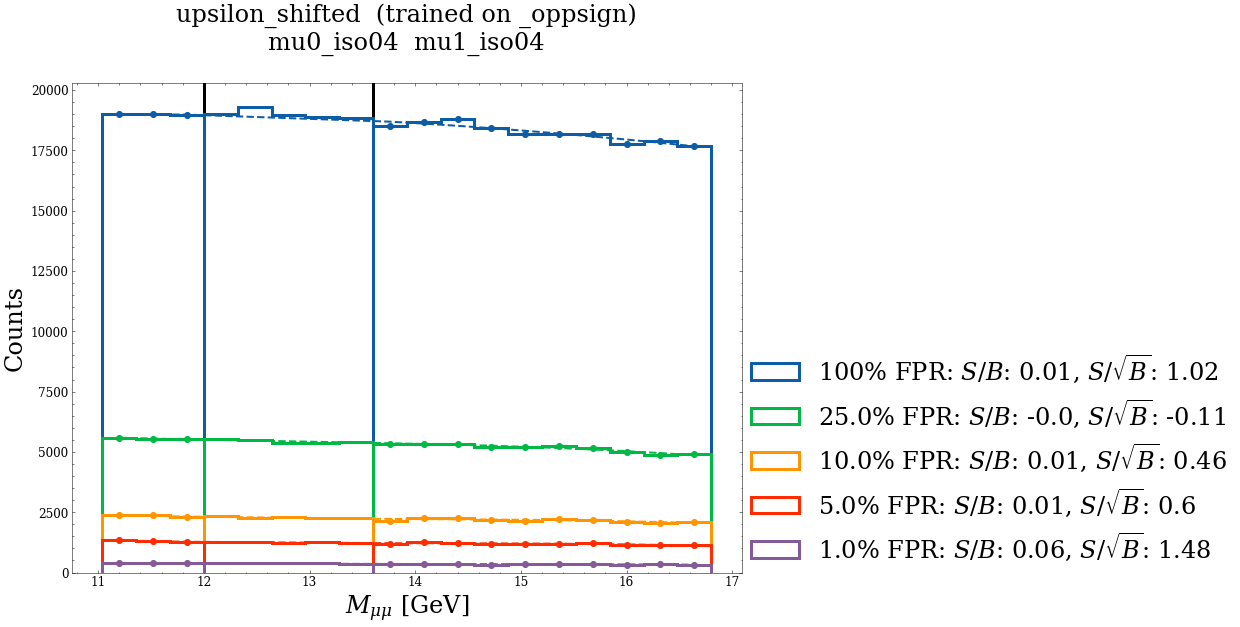

In [13]:
SB_left = float(workflow[particle_type]["SB_left"])
SR_left = float(workflow[particle_type]["SR_left"])
SR_right = float(workflow[particle_type]["SR_right"])
SB_right = float(workflow[particle_type]["SB_right"])
    
TPRs, FPRs = [], []

remove_edge = True


    
    
x = np.linspace(SB_left, SB_right, 100)

# get bins, bin centers
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, remove_edge)


fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio


plt.figure(figsize = (12, 9))
for t, threshold in enumerate(fpr_thresholds):
    
    # corrections to SR / SB efficiencies
    filtered_masses = []
    
    for i_fold in range(n_folds):
        

        loc_true_masses = scaler.inverse_transform(np.array(all_alt_data_splits[pseudo_e_to_plot]["ROC"][i_fold][:,-1]).reshape(-1,1))
        loc_scores = all_alt_scores_splits[pseudo_e_to_plot]["ROC"][i_fold]
        loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs[pseudo_e_to_plot][i_fold][threshold],
                                                                                           plot_bins_left, plot_bins_right, plot_bins_SR)
        

        filtered_masses.append(loc_filtered_masses)

        

    filtered_masses = np.concatenate(filtered_masses)

    
    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all,)
    #print("chi2/dof:", chi2/n_dof)
    # plot the fit function
    plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
    
    # calculate significance of bump
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, SR_left, SR_right, popt)


    y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
    plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")
    
    

print() 
plt.legend(loc = (1, 0), fontsize = 24)


plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.title(f"{particle_type} {ROC_test_data_id} (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", fontsize = 24)
plt.show()


## ROC curve


### True classifier uncertainty

In [14]:
TPRs, FPRs = [], []

remove_edge = True
      
fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio


fpr_thresholds = np.logspace(0, -3, 20)
#fpr_thresholds = np.linspace(1, 0 , 50)

# first determine score cutoffs
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_bootstraps)}

for pseudo_e in range(num_bootstraps):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff


S_yield, B_yield = np.empty((fpr_thresholds.shape[0], num_bootstraps)), np.empty((fpr_thresholds.shape[0], num_bootstraps))

for pseudo_e in range(num_bootstraps):
    
    print(f"On pseudo experiment {pseudo_e}...")
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_masses_bs = []
    
        for i_fold in range(n_folds):
            

            loc_true_masses_bs = scaler.inverse_transform(np.array(all_alt_data_splits[pseudo_e]["ROC"][i_fold][:,-1]).reshape(-1,1))
            
            loc_scores_bs = all_alt_scores_splits[pseudo_e]["ROC"][i_fold]
            # filter top event based on score cutoff
            loc_filtered_masses_bs, _, _, _ = select_top_events_fold(loc_true_masses_bs, loc_scores_bs, score_cutoffs[pseudo_e][i_fold][threshold], plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses_bs.append(loc_filtered_masses_bs)

        filtered_masses_bs = np.concatenate(filtered_masses_bs)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses_bs, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses_bs, fit_function, plot_bins_SR, SR_left, SR_right, popt)
        
        S_yield[t, pseudo_e] = num_S_expected_in_SR
        B_yield[t, pseudo_e] = num_B_expected_in_SR


print("All done!")      
        


On pseudo experiment 0...
On pseudo experiment 1...
On pseudo experiment 2...
On pseudo experiment 3...
On pseudo experiment 4...
On pseudo experiment 5...
On pseudo experiment 6...
On pseudo experiment 7...
On pseudo experiment 8...
On pseudo experiment 9...
All done!


In [15]:



# calculate summary stats
TPR = S_yield/S_yield[0,:]
FPR = B_yield/B_yield[0,:]

ROC = 1.0/FPR

SIC = TPR/np.sqrt(FPR)


def get_median_percentiles(x_array):
    
    
    x_median = np.median(x_array, axis = 1)
    x_lower = np.percentile(x_array, 16, axis = 1)
    x_upper = np.percentile(x_array, 84, axis = 1)

    return x_median, x_lower, x_upper


Classifier trained on ['mu0_iso04', 'mu1_iso04']


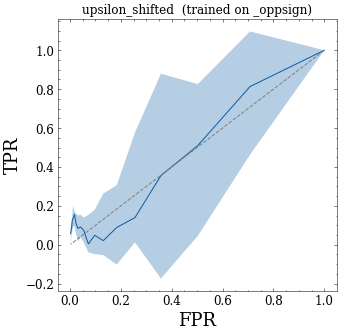

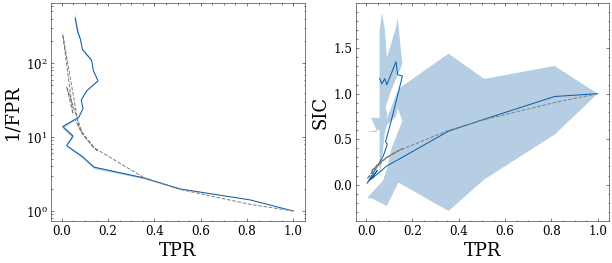

In [16]:
TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)
FPR_median, FPR_lower, FPR_upper = get_median_percentiles(FPR)
ROC_median, ROC_lower, ROC_upper = get_median_percentiles(ROC)
SIC_median, SIC_lower, SIC_upper = get_median_percentiles(SIC)

print(f"Classifier trained on {feature_set[:-1]}")

plt.figure(figsize = (5, 5))



plt.plot(FPR_median, TPR_median)
plt.fill_between(FPR_median, TPR_lower, TPR_upper, alpha = 0.3 )

plt.plot(FPR_median, FPR_median, linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.ylabel("TPR")


plt.title(f"{particle_type} {ROC_test_data_id} (trained on {train_data_id_title})")


fig, ax = plt.subplots(1, 2, figsize = (10, 4))


ax[0].plot(TPR_median, ROC_median)
ax[0].fill_between(TPR_median, ROC_lower, ROC_upper, alpha = 0.3 )
ax[0].plot(TPR_median, 1.0/TPR_median, linestyle = "dashed", color = "grey")
ax[0].set_xlabel("TPR")
ax[0].set_ylabel("1/FPR")
ax[0].set_yscale("log")


    
ax[1].plot(TPR_median, SIC_median)
ax[1].fill_between(TPR_median, SIC_lower, SIC_upper, alpha = 0.3 )
ax[1].plot(TPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey")
ax[1].set_xlabel("TPR")
ax[1].set_ylabel("SIC")


plt.show()